In [63]:
!pip install -U -q PyDrive
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

In [65]:
# Autenticação de conta.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
# from google.colab import drive
# drive.mount('/content/drive')

In [68]:
from joblib import load

In [69]:
rf_loaded = load('/content/drive/MyDrive/Colab Notebooks/modelos/modelo_atritado.model')
rf_loaded

RandomForestClassifier()

In [70]:
import pandas as pd
downloaded = drive.CreateFile({'id': '1-ADMS6ovcQYfSHtYPuEDAUSQRAFkJs6W'})
downloaded.GetContentFile('april.csv')
dataframe = pd.read_csv("april.csv")

In [71]:
def normalizeColumn(dataFrame, columnName): 
  return (dataFrame[columnName] - dataFrame[columnName].min()) / (dataFrame[columnName].max() - dataFrame[columnName].min()) 

def tratamento_dados_atritado(dataframe):
  dataframe["vlr_renda"] = dataframe["vlr_renda"].str.replace(',','.')
  dataframe["vlr_renda"] = dataframe["vlr_renda"].astype(float)

  dataframe['ind_atrito'] = dataframe['ind_atrito'].fillna(0)
  dataframe['ind_engaj'] = dataframe['ind_engaj'].fillna(0)
  dataframe['ind_novo_cli'] = dataframe['ind_novo_cli'].fillna(0)
  dataframe['num_atend'] = dataframe['num_atend'].fillna(0)
  dataframe['num_atend_atrs'] = dataframe['num_atend_atrs'].fillna(0)
  dataframe['qtd_reclm'] = dataframe['qtd_reclm'].fillna(0) 

  client = dataframe[dataframe.cod_rating.notna()]

  client = client.drop('cod_rating', axis=1)
  client = client.drop('ind_novo_cli', axis=1)
  client = client.drop('num_cpf_hash', axis=1)
  client = client.drop('anomes', axis=1)
  # client = client.drop('ind_atrito', axis=1)
  client = client.drop('ind_engaj', axis=1)
  client = client.dropna()

  from sklearn.preprocessing import MinMaxScaler

  clientNormalizeColumns = ['vlr_credito', 'vlr_saldo', 'num_atend_atrs', 
       'num_produtos', 'num_atend', 'qtd_oper', 'qtd_reclm', 'qtd_restr',
       'vlr_renda']


  for column in clientNormalizeColumns:
    client[column] = normalizeColumn(client, column)

  client[['vlr_score']] = StandardScaler().fit_transform(client[['vlr_score']])

  return client

In [72]:
formated_df = tratamento_dados_atritado(dataframe)

Reordenando colunas do dataframe

In [73]:
cols = ['vlr_saldo','vlr_credito', 'num_atend_atrs', 'qtd_reclm','vlr_renda','num_atend', 'num_produtos', 'qtd_oper', 'vlr_score', 'qtd_restr']
formated_df_y = formated_df['ind_atrito']
formated_df = formated_df[cols]

In [74]:
y_pred = rf_loaded.predict(formated_df)

In [75]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [76]:
formated_df

,vlr_saldo,vlr_credito,num_atend_atrs,qtd_reclm,vlr_renda,num_atend,num_produtos,qtd_oper,vlr_score,qtd_restr
1,0.002814,0.004815,0.0,0.0,0.002778,0.0,0.0125,0.100775,0.396538,0.000000
4,0.000295,0.005937,0.0,0.0,0.004028,0.0,0.0000,0.186047,-2.068178,0.016949
5,0.002905,0.015490,0.0,0.0,0.006389,0.0,0.0000,0.131783,3.314884,0.000000
9,0.001625,0.003176,0.0,0.0,0.003194,0.0,0.0250,0.046512,0.373857,0.000000
10,0.021744,0.013295,0.0,0.0,0.010000,0.0,0.0375,0.139535,0.978695,0.016949
...,...,...,...,...,...,...,...,...,...,...
987906,0.002223,0.005299,0.0,0.0,0.011389,0.0,0.1125,0.178295,-1.962331,0.025424
987913,0.012493,0.007083,0.0,0.0,0.032500,0.0,0.0000,0.038760,2.861255,0.008475
987918,0.000843,0.108792,0.0,0.0,0.094028,0.0,0.0000,0.240310,-0.359510,0.033898
987920,0.000645,0.003948,0.0,0.0,0.006250,0.0,0.0250,0.139535,-1.856484,0.008475


In [77]:
accuracy_score(formated_df_y, y_pred) # Mostra a acurácia do modelo.

0.9020455889289725

In [79]:
precision_score(formated_df_y, y_pred) # Mostra a precisão do modelo.

0.0031847133757961785

In [80]:
recall_score(formated_df_y, y_pred) # Mostra a revocação do modelo.

0.5875

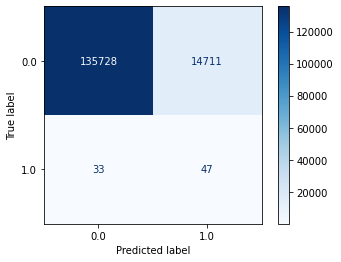

In [81]:
plot_confusion_matrix(rf_loaded,formated_df,formated_df_y, cmap='Blues') 